In [ ]:
# !apt-get install python3-dev graphviz libgraphviz-dev pkg-config

# !pip install -qU \
#     langchain-openai==0.1.3 \
#     langchain==0.1.16 \
#     langchain-core==0.1.42 \
#     langgraph==0.0.37 \
#     langchainhub==0.1.15 \
#     # pygraphviz==1.12  # for visualizing the graph

In [1]:
from typing import TypedDict, Annotated, List, Union

from langchain_core.agents import AgentAction, AgentFinish
import operator

class AgentState(TypedDict):
    input: str # accepts user's input as string
    agent_out : Union[AgentAction, AgentFinish, None] # gives output
    intermediate_steps: Annotated[List[tuple[AgentAction, str]], operator.add] # shows intermediate steps

In [2]:
with open("prompts/sample_data.txt", 'r') as file:
    data = file.read().strip()

In [3]:
print(data)

### Immediate Care for Handling Mental Health Crisis

What is Immediate Care?
1. Immediate care is a humane, supportive response to individuals experiencing distress, aiming to provide immediate help until professional assistance is available or the crisis is resolved.
2. It is accessible to all, not limited to mental health professionals.
3. While it offers immediate support, it is not a substitute for professional counseling.

Importance of Immediate Care
1. Mental health disorders can affect anyone, regardless of age, gender, race, or socioeconomic status.
2. Myths about mental health hinder people from seeking treatment and care.
3. Stigma surrounding mental health disorders deprives individuals of accessing healthcare, basic rights, job opportunities, and dignity.
4. Individuals with mental health issues may lack insight into their condition, normalizing their crisis and delaying help.
5. Many face challenges in accessing mental health professionals during a crisis due to insuffic

# Format 
final_answer tool — which provides output in a specific format, ie:
{
    "answer": "<LLM generated answer here>",
    "source": "<LLM generated citation here>"
}

In [ ]:
import os.path
import logging
import sys

from llama_index.core import (
    VectorStoreIndex,
    SimpleDirectoryReader,
    StorageContext,
    load_index_from_storage,
)
# Viewing Queries and Events Using Logging
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

# loading env variables 
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

openai_api_key = os.getenv("OPENAI_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")

In [ ]:
# llama-index function
def llama_index(query: str):
    
    PERSIST_DIR = "./storage"
    if not os.path.exists(PERSIST_DIR):
        documents = SimpleDirectoryReader("prompts").load_data()
        # By default, LlamaIndex uses a chunk size of 1024 and a chunk overlap of 20
        index = VectorStoreIndex.from_documents(documents)
        index.storage_context.persist(persist_dir=PERSIST_DIR)
    else:
        storage_context = StorageContext.from_defaults(persist_dir=PERSIST_DIR)
        index = load_index_from_storage(storage_context)
    
    query_engine = index.as_query_engine()
    # query_engine = index.as_query_engine(similarity_top_k=2, streaming=True) # to enable streaming
    # chat_engine = index.as_chat_engine() # to use chat engine for conversational search

    response = query_engine.query(query)
    # streaming_response = query_engine.query(query)
    # streaming_response.print_response_stream()
    # response = chat_engine.chat(query)
    return str(response)


In [ ]:
llama_index("what is immediate care?")

In [19]:
from langchain_core.tools import tool

@tool("search")
def search_tool(query: str):
    """Searches for information on the topic of provinding immediate care."""
    # this is a "RAG" emulator
    # add RAG code
    answer = llama_index(query)
    return answer

@tool("final_answer")
def final_answer_tool(
    answer: str,
    source: str
):
    """Returns a natural language response to the user in `answer`, and a
    `source` from where this data is sourced from.
    """
    return ""



# start

In [ ]:
import os
from langchain.agents import create_openai_tools_agent
from langchain import hub
from langchain_openai import ChatOpenAI
# export LANGCHAIN_TRACING_V2="true"
# export LANGCHAIN_API_KEY="<key>"

llm = ChatOpenAI(
    model="gpt-3.5-turbo", # gpt-4o
    openai_api_key=os.environ["OPENAI_API_KEY"],
    temperature=0.1
)

prompt = hub.pull("hwchase17/openai-functions-agent")

In [21]:
query_agent_runnable = create_openai_tools_agent(
    llm=llm,
    tools=[final_answer_tool, search_tool],
    prompt=prompt
)
# type: <class 'langchain_core.runnables.base.RunnableSequence'>

In [22]:
print(query_agent_runnable)

first=RunnableAssign(mapper={
  agent_scratchpad: RunnableLambda(lambda x: format_to_openai_tool_messages(x['intermediate_steps']))
}) middle=[ChatPromptTemplate(input_variables=['agent_scratchpad', 'input'], input_types={'chat_history': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]], 'agent_scratchpad': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, metadata={'lc_hub_owner': 'hwchase17', 'lc_hub_repo': 'openai-functions-agent', 'lc_hub_commit_hash': 'a1655024b06afbd95d17449f21316291e0726f13dcfaf990cc0d18087ad6

In [ ]:
# test

inputs = {
    "input": "What are Probing Skills?",
    "intermediate_steps": []
}
agent_out = query_agent_runnable.invoke(inputs)
agent_out

In [25]:
agent_out[-1].message_log[-1].additional_kwargs["tool_calls"][-1]

{'id': 'call_ajwSVjUlIRYHGt7cfayNpNQi',
 'function': {'arguments': '{"query":"Probing Skills"}', 'name': 'search'},
 'type': 'function'}

### Define Nodes for Graph

In [26]:
from langchain_core.agents import AgentFinish
import json

def run_query_agent(state: list):
    print("> run_query_agent")
    agent_out = query_agent_runnable.invoke(state)
    return {"agent_out": agent_out}

def execute_search(state: list):
    print("> execute_search")
    action = state["agent_out"]
    tool_call = action[-1].message_log[-1].additional_kwargs["tool_calls"][-1]
    out = search_tool.invoke(
        json.loads(tool_call["function"]["arguments"])
    )
    return {"intermediate_steps": [{"search": str(out)}]}

def router(state: list):
    print("> router")
    if isinstance(state["agent_out"], list) and state["agent_out"]:
        return state["agent_out"][-1].tool
    else:
        return "error"

# finally, we will have a single LLM call that MUST use the final_answer structure
final_answer_llm = llm.bind_tools([final_answer_tool], tool_choice="final_answer")

# this forced final_answer LLM call will be used to structure output from our
# RAG endpoint
def rag_final_answer(state: list):
    print("> final_answer")
    query = state["input"]
    context = state["intermediate_steps"][-1]

    prompt = f"""You are a helpful assistant, answer the user's question using the
    context provided.

    CONTEXT: {context}

    QUESTION: {query}
    """
    out = final_answer_llm.invoke(prompt)
    function_call = out.additional_kwargs["tool_calls"][-1]["function"]["arguments"]
    return {"agent_out": function_call}

# we use the same forced final_answer LLM call to handle incorrectly formatted
# output from our query_agent
def handle_error(state: list):
    print("> handle_error")
    query = state["input"]
    prompt = f"""You are a helpful assistant, answer the user's question.

    QUESTION: {query}
    """
    out = final_answer_llm.invoke(prompt)
    function_call = out.additional_kwargs["tool_calls"][-1]["function"]["arguments"]
    return {"agent_out": function_call}

# Define Graph

A node represents a function (one of those we just defined above) whereas an edge allows us to travel from one node to another.

Let's start by initializing our graph using our AgentState object and adding our first set of nodes and the graph entry point (ie where the graph begins once called).

In [27]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

# we have four nodes that will consume our agent state and modify
# our agent state based on some internal process
graph.add_node("query_agent", run_query_agent)
graph.add_node("search", execute_search)
graph.add_node("error", handle_error)
graph.add_node("rag_final_answer", rag_final_answer)

# our graph will always begin with the query agent
graph.set_entry_point("query_agent")

# conditional edges are controlled by our router
graph.add_conditional_edges(
    start_key="query_agent",  # where graph start
    condition=router,  # function to determine which node is called
    conditional_edge_mapping={
        "search": "search",
        "error": "error",
        "final_answer": END
    }
)
graph.add_edge("search", "rag_final_answer")
graph.add_edge("error", END)
graph.add_edge("rag_final_answer", END)

runnable = graph.compile()

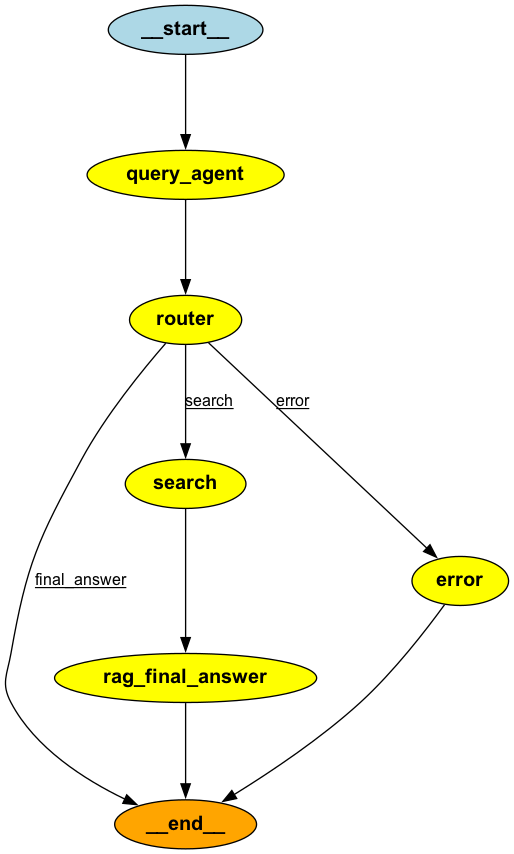

In [28]:
# to see the graph using pygraphviz
from IPython.display import Image

Image(runnable.get_graph().draw_png())

In [ ]:
# sample run

runnable = graph.compile()

out = runnable.invoke({
    "input": "what I should not do in providing immediate care?",
    "intermediate_steps": []
})

In [30]:
print(out["agent_out"])

{"answer":"In providing immediate care, you should not pressure someone to tell their story, interrupt or rush the story, give simple, unrealistic reassurances, give false promises or minimize their loss, touch if unsure, or criticize existing services in front of people in need.","source":"Providing immediate care guidelines"}


In [31]:
# printing in nice format
import pprint

text = json.dumps(out["agent_out"], indent = 2)
output_text = {
    "agent_out": {text}
}

final_output = json.loads(out["agent_out"])
print(json.dumps(final_output, indent=2))
# pprint.pprint(final_output, width=60)

{
  "answer": "In providing immediate care, you should not pressure someone to tell their story, interrupt or rush the story, give simple, unrealistic reassurances, give false promises or minimize their loss, touch if unsure, or criticize existing services in front of people in need.",
  "source": "Providing immediate care guidelines"
}


In [32]:
# to see intermediate steps 
pprint.pprint(out, indent = 4)

{   'agent_out': '{"answer":"In providing immediate care, you should not '
                 'pressure someone to tell their story, interrupt or rush the '
                 'story, give simple, unrealistic reassurances, give false '
                 'promises or minimize their loss, touch if unsure, or '
                 'criticize existing services in front of people in '
                 'need.","source":"Providing immediate care guidelines"}',
    'input': 'what I should not do in providing immediate care?',
    'intermediate_steps': [   {   'search': 'Do not pressure someone to tell '
                                            'their story, do not interrupt or '
                                            'rush the story, do not give '
                                            'simple, unrealistic reassurances, '
                                            'do not give false promises or '
                                            'minimize their loss, do not touch '
           

In [29]:
# error case
out = runnable.invoke({
    "input": "hi",
    "intermediate_steps": []
})
print(out["agent_out"])

> run_query_agent
> router
> handle_error
{"answer":"Hello! How can I assist you today?","source":"N/A"}
